In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

import pandas as pd
import pandas_datareader.data as pdr
import datetime
import argparse

from torch.utils.data import TensorDataset, DataLoader


import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [18]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime

start = (2000, 1, 1)
start = datetime.datetime(*start)
end = datetime.date.today()

df_sk = pdr.DataReader('096770', 'naver', start, end)
print(df_sk.head())
print(df_sk.tail())

              Open    High     Low   Close   Volume
Date                                               
2007-07-25  160000  170000  155000  169500  2853735
2007-07-26  168000  169500  150000  150000  2132041
2007-07-27  147000  159000  139000  148000  1205584
2007-07-30  145000  157500  145000  157500   571034
2007-07-31  155000  159000  152500  157000   368700
              Open    High     Low   Close  Volume
Date                                              
2022-05-31  211000  216500  209500  215500  732337
2022-06-02  215500  217500  214000  215500  232250
2022-06-03  219000  226000  218000  225500  598041
2022-06-07  230000  236500  229500  236500  969107
2022-06-08  239500  243000  235000  239500  690131


In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_sk[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df_sk[['Open','High','Low','Close','Volume']])
df_sk.head()

,Open,High,Low,Close,Volume
Date,,,,,
2007-07-25,0.412186,0.427064,0.410460,0.449507,0.460221
2007-07-26,0.440860,0.425246,0.391979,0.376976,0.341335
2007-07-27,0.365591,0.387050,0.351321,0.369537,0.188719
2007-07-30,0.358423,0.381593,0.373498,0.404873,0.084189
2007-07-31,0.394265,0.387050,0.401220,0.403013,0.050858


In [40]:
from sklearn.preprocessing import PolynomialFeatures

X_temp = df_sk[['Open','High','Low','Volume']].values
y = df_sk['Close'].values

poly = PolynomialFeatures(degree=2, include_bias=True)
poly.fit(X_temp)

X = poly.transform(X_temp)
print(X.shape, y.shape)

(3674, 15) (3674,)


In [37]:
feature = np.delete(df_sk.keys().values, 3)

# ===== make feature name list ===== #
feature_name = []
for i in range(len(feature)):
    for j in range(len(feature)):
        feature_name.append(feature[i] + ' x ' + feature[j])
feature_name = np.append('bias', np.append(feature, np.delete(feature_name, [4, 8, 9, 12, 13, 14])))
print(feature_name)

['bias' 'Open' 'High' 'Low' 'Volume' 'Open x Open' 'Open x High'
 'Open x Low' 'Open x Volume' 'High x High' 'High x Low' 'High x Volume'
 'Low x Low' 'Low x Volume' 'Volume x Volume']


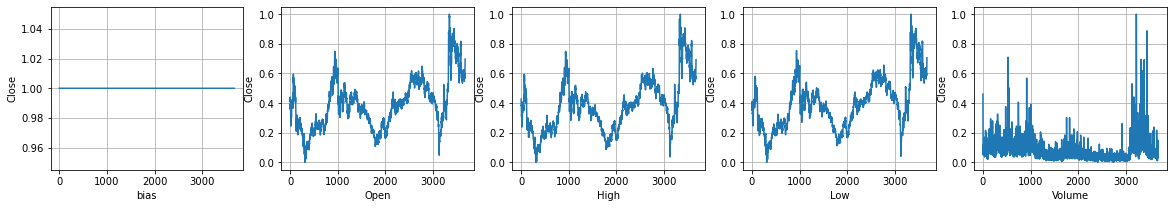

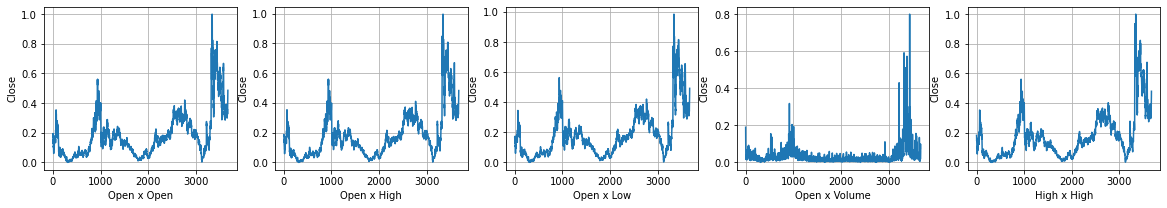

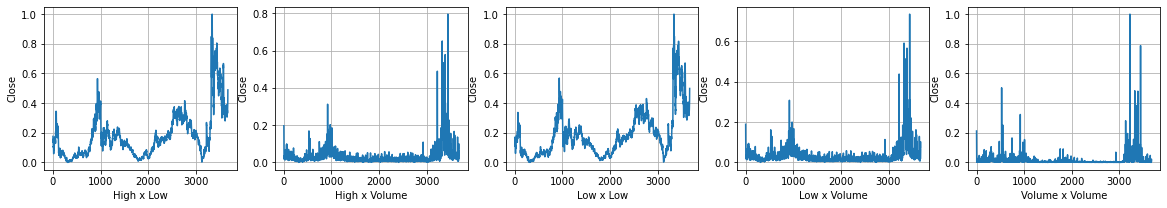

In [45]:
for i in range(3):
    plt.figure(figsize=(20,3))
    plt.subplot(1, 5, 1)
    plt.plot(X[:, 5*i])
    plt.xlabel(feature_name[5*i])
    plt.ylabel('Close')
    plt.grid()

    plt.subplot(1, 5, 2)
    plt.plot(X[:, 5*i+1])
    plt.xlabel(feature_name[5*i+1])
    plt.ylabel('Close')
    plt.grid()

    plt.subplot(1, 5, 3)
    plt.plot(X[:, 5*i+2])
    plt.xlabel(feature_name[5*i+2])
    plt.ylabel('Close')
    plt.grid()

    plt.subplot(1, 5, 4)
    plt.plot(X[:, 5*i+3])
    plt.xlabel(feature_name[5*i+3])
    plt.ylabel('Close')
    plt.grid()

    plt.subplot(1, 5, 5)
    plt.plot(X[:, 5*i+4])
    plt.xlabel(feature_name[5*i+4])
    plt.ylabel('Close')
    plt.grid()
    
    plt.show()

### **Model**

In [23]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hid_dim, out_dim, num_layers, batch_size):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(self.input_dim, self.hid_dim, self.num_layers)
        self.linear = nn.Sequential(nn.Linear(self.hid_dim, self.hid_dim//2),
                                    nn.ReLU(),
                                    nn.Linear(self.hid_dim//2, self.out_dim)
                                   )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        linear_out = self.linear(lstm_out[:, -1].reshape(-1, self.hid_dim))
        
        return linear_out


### **Functions**

In [ ]:
def data_setting(X, y, args):
    x_length, y_length = args.x_frames, args.y_frames   # 21 , 3
    x_seq = []
    y_seq = []
    
    for i in range(len(X) - args.x_frames - args.y_frames + 1):
        x_seq.append(X[i:i+x_length])
        y_seq.append(y[i+x_length:i+x_length+y_length])
        
    X_train, y_train = x_seq[:int(len(x_seq)*0.7)], y_seq[:int(len(y_seq)*0.7)]
    X_val, y_val = x_seq[int(len(x_seq)*0.7):], y_seq[int(len(y_seq)*0.7):]

    train_set = (torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_set = (torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    
    return train_set, val_set

In [61]:
train_set, val_set = data_setting(X, y, args)
print(train_set[0].shape, train_set[1].shape)
print(va_set[1].shape, val_set[1].shape)

torch.Size([2555, 21, 15]) torch.Size([2555, 3])
torch.Size([1096, 21, 15]) torch.Size([1096, 3])


In [47]:
def train(model, partition, optimizer, criterion, args):   
    
    model.train()
    
    X, y = partition['train']
    X, y = X.to(args.device), y.to(args.device)

    optimizer.zero_grad()

    y_pred = model(X)
    loss = criterion(y_pred, y)
        
    loss.backward()
    optimizer.step()

    train_loss = loss.item()
    return model, train_loss
    
    
def validation(model, partition, criterion, args):    
    model.eval()
    
    X, y = partition['val']
    X, y = X.to(args.device), y.to(args.device)

    y_pred = model(X)
    loss = criterion(y_pred, y)

    val_loss = loss.item()
    return val_loss

In [48]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.out_dim, args.n_layers, args.batch_size)
    model.to(args.device)
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr) 
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        model, train_loss = train(model, partition, optimizer, criterion, args)
        val_loss = validation(model, partition, criterion, args)
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if epoch%50 == 0 or epoch==args.epoch-1:
            print(f"[{epoch}/{args.epoch}] Loss(train/val): {train_loss}/{val_loss}")


    return model, train_losses, val_losses

In [57]:
# ====== Random Seed Initialization ====== #
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = '096770'
args.batch_size = 16
args.x_frames = 21
args.y_frames = 3

# ====== Model Capacity ===== #
args.input_dim = X.shape[1]
args.hid_dim = 50
args.out_dim = args.y_frames
args.n_layers = 2

# ====== Optimizer & Training ====== 
args.lr = 0.00007
args.epoch = 2000

train_set, val_set = data_setting(X, y, args)
partition = {'train':train_set, 'val':val_set}

model, train_losses, val_losses = experiment(partition, args)

[0/2000] Loss(train/val): 0.12162903696298599/0.2997773289680481
[50/2000] Loss(train/val): 0.10186932981014252/0.26722022891044617
[100/2000] Loss(train/val): 0.07638277858495712/0.22202536463737488
[150/2000] Loss(train/val): 0.037992484867572784/0.1338244527578354
[200/2000] Loss(train/val): 0.012037765234708786/0.045877330005168915
[250/2000] Loss(train/val): 0.008136745542287827/0.028566963970661163
[300/2000] Loss(train/val): 0.004534673411399126/0.015315140597522259
[350/2000] Loss(train/val): 0.003034041728824377/0.010609764605760574
[400/2000] Loss(train/val): 0.0026718503795564175/0.010156230069696903
[450/2000] Loss(train/val): 0.002414741087704897/0.009992741048336029
[500/2000] Loss(train/val): 0.0022245445288717747/0.009726542048156261
[550/2000] Loss(train/val): 0.00207689986564219/0.009353353641927242
[600/2000] Loss(train/val): 0.001953807193785906/0.008887002244591713
[650/2000] Loss(train/val): 0.0018447559559717774/0.008350454270839691
[700/2000] Loss(train/val): 0.

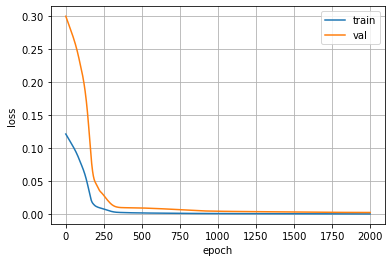

In [58]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

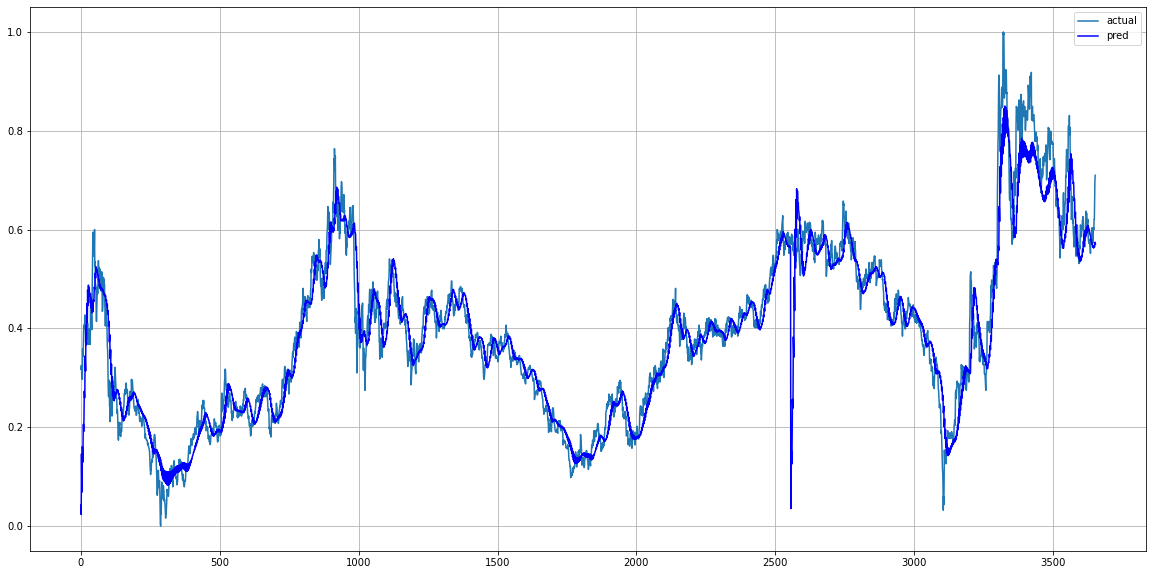

In [59]:
def plotting(model, partition, args):
    with torch.no_grad():
        total = np.array([])
        
        X, y = partition['train']
        X, y = X.to(args.device), y.to(args.device)
        
        step = np.arange(0, len(X), args.y_frames)
        
        out = model(X[step])
        total = np.append(total, out.cpu().numpy().tolist())
        

        X, y = partition['val']
        X, y = X.to(args.device), y.to(args.device)
        
        step = np.arange(0, len(X), args.y_frames)
        
        out = model(X[step])
        total = np.append(total, out.cpu().numpy().tolist())

    total = np.array(total).reshape(-1)
    return total

total = plotting(model, partition, args)

plt.figure(figsize=(20,10))
plt.plot(y[args.x_frames:], label = 'actual')
plt.plot(total, 'b', label='pred')
plt.legend()
plt.grid()
plt.show()